In [1]:
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyunitwizard as puw

In [2]:
pdb = app.PDBFile('barnase_barstar.pdb')
original_positions = pdb.getPositions(asNumpy=True)

In [3]:
num_total_atomos = original_positions.shape[0]



In [4]:
list_chains = list(pdb.topology.chains())
print(f'Tenemos {len(list_chains)} cadenas de átomos en ek pdb')

Tenemos 2 cadenas de átomos en ek pdb


In [5]:
num_atomos_cadena_1 = len(list(list_chains[0].atoms()))
num_atomos_cadena_2 = len(list(list_chains[1].atoms()))

print(f'En la cadena 1 tenemos {num_atomos_cadena_1} átomos')
print(f'En la cadena 2 tenemos {num_atomos_cadena_2} átomos')

En la cadena 1 tenemos 1727 átomos
En la cadena 2 tenemos 1432 átomos


In [6]:
indices_1 = list(range(0,num_atomos_cadena_1)) # Indices of molecule 1
indices_2 = list(range(num_atomos_cadena_1,num_total_atomos)) # Indices of molecule 2


In [7]:
original_positions_1=original_positions[indices_1]
original_positions_2=original_positions[indices_2]

In [8]:
centro_1 = np.mean(original_positions_1, 0)
centro_2 = np.mean(original_positions_2, 0)

In [9]:
original_positions_1=original_positions[indices_1]
original_positions_2=original_positions[indices_2]

In [10]:
r=centro_2-centro_1
original_dist_centros = np.linalg.norm(r)
original_dist_centros

2.3962948699429214

In [11]:
original_dist_centros = original_dist_centros * r.unit


In [12]:
original_dist_centros

Quantity(value=2.3962948699429214, unit=nanometer)

In [13]:
vec_normalizado=r/original_dist_centros


In [14]:
vec_normalizado

array([ 0.03898872, -0.46648492,  0.88366945])

In [15]:
forcefield = app.ForceField('amber14-all.xml')

system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

step_size   = 0.002*unit.picoseconds
temperature = 0.0*unit.kelvin
friction    = 0.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CPU'
platform    = mm.Platform.getPlatformByName(platform_name)

context = mm.Context(system, integrator, platform)

In [16]:

context.setPositions(original_positions)
state = context.getState(getEnergy=True)
state.getPotentialEnergy()

Quantity(value=15294.695710703112, unit=kilojoule/mole)

In [17]:
distancias_entre_centros = []
energias_potenciales = []

In [18]:
N = 1000
delta_x = 0.025 * unit.nanometers

In [19]:

for ii in tqdm(range(N)):
    temporal_position_2 = original_positions_2 + ii*delta_x*vec_normalizado
    new_positions = original_positions
    new_positions[indices_2,:] = temporal_position_2[:,:] # Actualizo las coordenadas de la molécula 2
    context.setPositions(new_positions)
    state = context.getState(getEnergy=True)
    energia_potencial= state.getPotentialEnergy() # Calculo la energía potencial
    # Guardo los valores
    distancias_entre_centros.append(original_dist_centros+ii*delta_x)
    energias_potenciales.append(energia_potencial)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.68it/s]


In [20]:
energias_potenciales = puw.concatenate(energias_potenciales)
distancias_entre_centros = puw.concatenate(distancias_entre_centros)


/home/diego/Myopt/miniconda3/envs/OpenDocker-Tools@dprada_3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


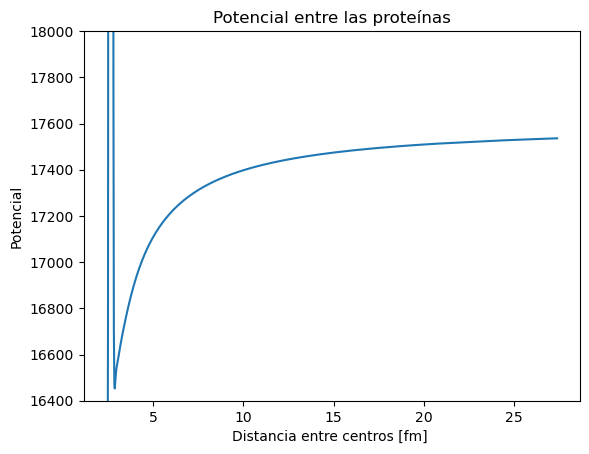

In [21]:
plt.plot(distancias_entre_centros ,energias_potenciales)
plt.ylim(16400,18000)
plt.xlabel('Distancia entre centros [fm] ')
plt.ylabel('Potencial')
plt.title('Potencial entre las proteínas')
plt.show()

In [29]:
#vamos a construir un espacio cúbico 
#este es un ejemplo para una partición del cubo que mide 
#definimos la cantidad de puntos en una dirección de la grid 
#que medirá diez nanómetros
tam = 7
a = np.linspace(-5,5,tam,True) 
#creamos listas vacías para llenarlas con los puntos de la grid
i = []
j = []
coord = []
#llenamos la grid con los puntos
for n in range(tam):
    for l in range(tam):
        for m in range(tam):
            coord.append([a[n],a[l],a[m]]*r.unit)

In [33]:
#ahora metemos todo en un ciclo para calcular 
#la energía potencial en cada punto
#creamos un vector para las coordenadas actualizadas
coordenadas_nuevas = []
energias_potenciales = []
for ii in tqdm(range(len(coord))):
    #no se necesita normalizar el vector dirección ahora sólo sumamos las coordenadas
    #de los vectores de posición a la posición de las otras partículas
    
    
    temporal_position_2 = original_positions_2 + coord[ii]
    new_positions = original_positions
    new_positions[indices_2,:] = temporal_position_2[:,:] # Actualizo las coordenadas de la molécula 2
    context.setPositions(new_positions)
    state = context.getState(getEnergy=True)
    energia_potencial= state.getPotentialEnergy() # Calculo la energía potencial
    # Guardo los valores
    coordenadas_nuevas.append(original_positions + coord[ii])
    energias_potenciales.append(energia_potencial)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:23<00:00, 14.35it/s]
